# A PyTorch Implementation of Algorithms in Optimal and Adaptive Algorithms for Online Boosting

## Dependencies: 
PyTorch, matplotlib, numpy, opencv-python

## Implementation Note

I consider labels of the form {0, 1} and cast to {-1, +1} where needed. This may not be appropriate or necessary, and may be changed in the future.

## Setup

In [1]:
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import torch.optim as optim
import matplotlib.pyplot as plt

plt_interval = 50

transform = transforms.Compose(
   [transforms.ToTensor()])

# get CIFAR10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# classes = ('cat', 'dog', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# create binary dataset 
label1 = 1; label2 = 7 # change if desired
trainset.train_labels = np.array(trainset.train_labels)
testset.test_labels = np.array(testset.test_labels)

# adjust train set
mask = (trainset.train_labels == label1) | (trainset.train_labels == label2)
trainset.train_data=trainset.train_data[mask]
trainset.train_labels=trainset.train_labels[mask]
mask1 = (trainset.train_labels == label1)
mask2 = (trainset.train_labels == label2)
trainset.train_labels[mask1] = -1
trainset.train_labels[mask2] = 1

# duplicate train set with horizontal flip and shuffle new array
permutation = np.random.permutation(len(trainset.train_labels))
trainset.train_data = np.concatenate([trainset.train_data, 
                                      np.flip(trainset.train_data[permutation], axis=2).copy()], 0)
trainset.train_labels = np.concatenate([trainset.train_labels, trainset.train_labels[permutation].copy()], 0)

# adjust test set
mask = (testset.test_labels == label1) | (testset.test_labels == label2)
testset.test_data=testset.test_data[mask]
testset.test_labels=testset.test_labels[mask]
mask1 = (testset.test_labels == label1)
mask2 = (testset.test_labels == label2)
testset.test_labels[mask1] = -1
testset.test_labels[mask2] = 1

# Grayscale and vectorize images
trainset.train_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in trainset.train_data])
testset.test_data = np.asarray([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in testset.test_data])
print("Dimensions of grayscaled vectorized images:", np.shape(trainset.train_data))

# load datasets for experiments: 1 at a time for training; 8 at a time for testing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("Data loaded:")
print("- Training set size:", len(trainset))
print("- Test set size:", len(testset))

Files already downloaded and verified
Files already downloaded and verified
Dimensions of grayscaled vectorized images: (20000, 32, 32)
Data loaded:
- Training set size: 20000
- Test set size: 2000


Test Images:


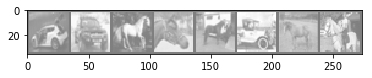

truck truck   car   car   car truck   car   car
Train Images:


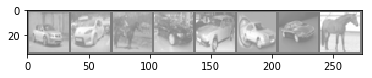

truck truck   car truck truck truck truck   car


Process Process-4:
Process Process-3:
Traceback (most recent call last):
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/dqi/.conda/envs/py36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(han

In [2]:
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random test images
dataiter = iter(testloader)
images = []; labels = []
img_count = 8
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Test Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# get some random train images
dataiter = iter(trainloader)
images = []; labels = []
for _ in range(img_count):
    image, label = dataiter.next()
    images.append(image)
    labels.append(label)
images = torch.from_numpy(np.concatenate(images, 0))
labels = torch.from_numpy(np.concatenate(labels, 0))

# show images
print("Train Images:")
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(img_count)))

# Weak Learner: Perceptron

In [3]:
# set learning rate
eta = 0.01

# get output of weak learner i
# o.w. get output of combination of WLs    
# returns label in {-1, +1}
def predict_WL(weak_learners, x, i=0):
    predict = np.dot(x, weak_learners[i])
    return -1 if (np.sign(predict) < 0) else 1

# update weak learner i
# accepts y in {-1, 1}
def update_WL(weak_learners, x, y, i):
    predict = predict_WL(weak_learners, x, i)
    if (predict*y) < 0:
        weak_learners[i] = weak_learners[i] + eta * x * y
    return weak_learners
    
# get output of combination of WLs (unweighted)
# returns label in {-1, +1}
def predict_WL_alg1(weak_learners, x):    
    N = len(weak_learners)
    prediction = 0
    for i in range(N):
        prediction += predict_WL(weak_learners, x, i)
    return -1 if (np.sign(prediction) < 0) else 1

# get output of combination of WLs (weighted)
# returns label in {-1, +1}
def predict_WL_alg2(weak_learners, x, alpha, i):
    prediction = 0
    for j in range(0, i+1):
        prediction += alpha[j] * predict_WL(weak_learners, x, j)
    return -1 if (np.sign(prediction) < 0) else 1

# Baseline - Weak Learner

In [4]:
def baseline(weak_learner, T):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_over_time = []
    
    # training
    for t, data in enumerate(trainloader, 1):   
        # perform T iterations
        if t > T: break
        
        # optimization step
        x, y = data
        x = x.numpy().flatten()
        predict = -1 if (np.sign(np.dot(x, weak_learner)) < 0) else 1 
        if (predict*y) < 0:
            weak_learner = weak_learner + eta * x * y
        
        n_mistakes += (predict != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
    
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
    
    return np.array(n_mistakes_over_time), weak_learner

# Online BBM 

In [5]:
# binomial helper function
def binom(a, b):
    return np.math.factorial(a) / (np.math.factorial(a-b) * np.math.factorial(b))

def onlineBBM(weak_learners, T, gamma):

    # keep track of metrics every 100 iterations
    n_mistakes = 0 
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)
    s = np.zeros(N+1)
    k = np.zeros(N+1)
    w = np.zeros(N+1)
    max_w = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y
        y_hat = predict_WL_alg1(weak_learners, x)        
        
        # N loop
        for j in range(1,N+1):
            
            # update values
            prediction = predict_WL(weak_learners, x, j-1)
            s[j] = s[j-1] + y * prediction
            k[j] = np.floor((N - j - s[j-1] + 1)/2)
            binom_term = 0 if (k[j] < 0 or k[j] > N - j) else binom(N-j, k[j])
            w[j] = binom_term * np.power(1/2 + gamma/2, k[j]) * np.power(1/2 - gamma/2, N - j - k[j])
            max_w[j] = max(w[j], max_w[j]) 
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability  
            prob = 1 if max_w[j] == 0 else w[j]/max_w[j]
            if np.random.random_sample() < prob:
                update_WL(weak_learners, x, y, j-1)
#                 print("updating", j, "data", t)
#                 predict = predict_WL(weak_learners, x, j-1)
#                 if (predict*y) < 0:
#                     weak_learners[j-1] = weak_learners[j-1] + eta * x * y
                
        # evaluate mistakes
        n_mistakes += (y_hat != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
        
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
                
    return n_mistakes_over_time, weak_learners

# AdaBoost OL

In [6]:
def adaboostOL(weak_learners, T, gamma):
    
    # keep track of metrics every 100 iterations
    n_mistakes = 0    
    n_mistakes_WL = np.zeros(len(weak_learners))
    n_mistakes_over_time = []
    
    # parameters
    N = len(weak_learners)    
    v = np.ones(N)
    alpha = np.zeros(N)
    y_hat = np.zeros(N+1)
    z = np.zeros(N+1)
    s = np.zeros(N+1)
    
    # T loop
    for t, data in enumerate(trainloader, 1):
        
        # perform T iterations
        if t > T: break
        
        # receive example and label
        x, y = data
        x = x.numpy().flatten()
        
        # predict y wrt each WL
        prediction = 0
        for j in range(N):            
            prediction += alpha[j] * predict_WL(weak_learners, x, j)
            y_hat[j] = -1 if (np.sign(prediction) < 0) else 1
            
        # model randomly chooses prediction of some WL
        v = v / np.sum(v)
        idx = np.random.choice(N, size=1, p=v)
        y_hat_final = y_hat[idx]
        
        # N loop
        for j in range(1,N+1):
            
            # set values
            prediction = predict_WL(weak_learners, x, j-1)
            z[j] = y * prediction
            s[j] = s[j-1] + alpha[j-1] * z[j]
            alpha[j-1] = max(-2, min(2, alpha[j-1] + (4 * z[j] / np.sqrt(t)) / (1 + np.exp(s[j]))))
            
            # count number of mistakes of weak learner
            n_mistakes_WL[j-1] += (prediction != y).item()
            
            # pass training example to WL j with some probability
            if np.random.random_sample() < 1 / (1 + np.exp(s[j-1])):
                update_WL(weak_learners, x, y, j-1)
                
            # update v
            indic = -1 if (y_hat_final != y) else 0
            v[j-1] = v[j-1] * np.exp(indic)
            
        # evaluate mistakes
        n_mistakes += (y_hat_final != y).item()
        if t % plt_interval == 0:
            n_mistakes_over_time.append(n_mistakes)
        if t % 1000 == 0:
            print("Fraction of mistakes by time %d" % t, n_mistakes / t)
            
    print("Fraction of mistakes after %d iterations:" % T, n_mistakes / (T))
       
    # output edge of each weak learner
    print("Edges of weak learners:\n", 0.5 - n_mistakes_WL / T)
    
    return n_mistakes_over_time, alpha

## Evaluate Models on Test Set

In [7]:
def evaluate_WLs(weak_learners):
    print("EVALUATING WEAK LEARNERS")
    
    for i in range(len(weak_learners)):
        correct = 0
        for data in testloader:
            x, y = data
            x = x.numpy().flatten()
            prediction = predict_WL(weak_learners, x, i)
            correct += (prediction == y).sum()
        print('Accuracy of weak learner', i, 'on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
        
def evaluate_model_onlineBBM(weak_learners):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    for data in testloader: 
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg1(weak_learners, x)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))
    
def evaluate_model_adaboostOL(weak_learners, alpha):
    print("\nEVALUATING MODEL")
    
    N = len(weak_learners)
    correct = 0
    total = 0
    for data in testloader:
        x, y = data
        x = x.numpy().flatten()
        prediction = predict_WL_alg2(weak_learners, x, alpha, N-1)
        correct += (prediction == y).sum().item()
    print('Accuracy of the network on the 2000 test images: %d %%' % (100 * correct / len(testloader)))

## Evaluate Models Online

In [8]:
def plot_loss(T, mistakes):
    error_rates = mistakes/ np.arange(plt_interval, T+1, plt_interval)
    plt.plot(np.arange(2*plt_interval, T+1, plt_interval), error_rates[1:])
    plt.title("Fraction of mistakes made online by the strong online learner")
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.show()

def evaluate_baseline(architecture, T):
    print("\033[1mEvaluating Baseline:\n\033[0m")
    
    weak_learner = np.zeros(1024)
    mistakes, weak_learner = baseline(weak_learner, T)
    evaluate_WLs([weak_learner])
    
    plot_loss(T, mistakes)
    
def evaluate_onlineBBM(N, T, architecture, gamma):
    print("\033[1mEvaluating Online BBM:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
    
    # test
    mistakes, weak_learners = onlineBBM(weak_learners, T, gamma)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_onlineBBM(weak_learners)
    
    plot_loss(T, mistakes)
    
def evaluate_adaboostOL(N, T, architecture, gamma):
    print("\033[1mEvaluating AdaBoost OL:\n\033[0m")
    
    # initialize N weak learners
    weak_learners = []
    for _ in range(N):
        weak_learners.append(np.zeros(1024)) 
        
    mistakes, alpha = adaboostOL(weak_learners, T, gamma)
    print()
    evaluate_WLs(weak_learners)
    print()
    evaluate_model_adaboostOL(weak_learners, alpha)
    
    plot_loss(T, mistakes)

## Baseline

Evaluating Baseline:

Fraction of mistakes after 10000 iterations: 0.3351
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 73 %


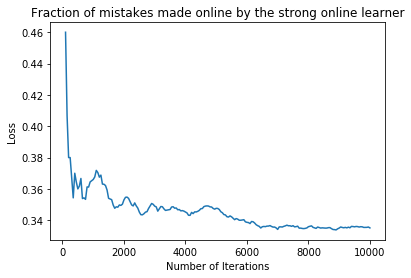

In [74]:
evaluate_baseline(architecture=0, T=10000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 2500 iterations: 0.3432
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 57 %


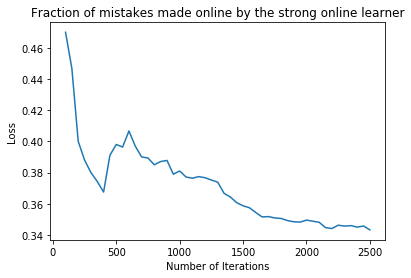

In [23]:
evaluate_baseline(architecture=0, T=2500) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 5000 iterations: 0.343
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 71 %


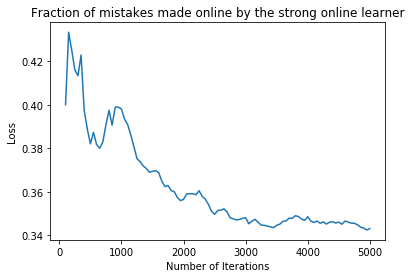

In [9]:
evaluate_baseline(architecture=0, T=5000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

Evaluating Baseline:

Fraction of mistakes after 20000 iterations: 0.32245
EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 76 %


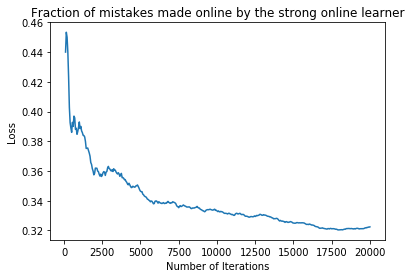

In [11]:
evaluate_baseline(architecture=0, T=20000) 
# 0.1 : 0.3428, 70% (5000) ;  0.326, 57 %
# 1 : 0.3438, 54 % (5000) ; 0.3267, 66 %

## Online BBM

In [ ]:
evaluate_onlineBBM(N=5, T=10000, architecture=2)

## Adaboost.OL

In [ ]:
evaluate_adaboostOL(N=5, T=5000, architecture=2)

## Run Experiments

In [13]:
def run_experiment(T=10000, N=10, net=0, model="bbm", gamma=0.2):
    evaluate = dict(bbm=evaluate_onlineBBM, adaboost=evaluate_adaboostOL)
    evaluate[model](N, T, net, gamma)
    
# ignore net input

In [ ]:
run_experiment(T=20000, N=5, net=0, model="adaboost")

# Different number of weak learners N

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.395
Fraction of mistakes by time 2000 0.348
Fraction of mistakes by time 3000 0.33266666666666667
Fraction of mistakes by time 4000 0.32175
Fraction of mistakes by time 5000 0.3138
Fraction of mistakes by time 6000 0.30883333333333335
Fraction of mistakes by time 7000 0.30357142857142855
Fraction of mistakes by time 8000 0.299375
Fraction of mistakes by time 9000 0.29544444444444445
Fraction of mistakes by time 10000 0.29
Fraction of mistakes after 10000 iterations: 0.29
Edges of weak learners:
 [0.1674 0.1788 0.2025 0.1895]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 54 %
Accuracy of weak learner 1 on the 2000 test images: 73 %
Accuracy of weak learner 2 on the 2000 test images: 77 %
Accuracy of weak learner 3 on the 2000 test images: 72 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 74 %


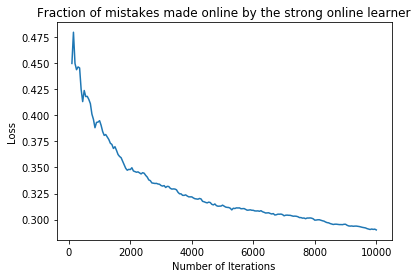

In [57]:
run_experiment(T=10000, N=4, net=0, model="bbm", gamma=0.1661)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.346
Fraction of mistakes by time 2000 0.323
Fraction of mistakes by time 3000 0.305
Fraction of mistakes by time 4000 0.30525
Fraction of mistakes by time 5000 0.2974
Fraction of mistakes by time 6000 0.29683333333333334
Fraction of mistakes by time 7000 0.29328571428571426
Fraction of mistakes by time 8000 0.291375
Fraction of mistakes by time 9000 0.2901111111111111
Fraction of mistakes by time 10000 0.2892
Fraction of mistakes after 10000 iterations: 0.2892
Edges of weak learners:
 [0.1672 0.1672 0.1752 0.1778 0.1951 0.1872 0.174  0.1694]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 69 %
Accuracy of weak learner 1 on the 2000 test images: 69 %
Accuracy of weak learner 2 on the 2000 test images: 70 %
Accuracy of weak learner 3 on the 2000 test images: 77 %
Accuracy of weak learner 4 on the 2000 test images: 75 %
Accuracy of weak learner 5 on the 2000 test images: 75 %
Accuracy of weak learner

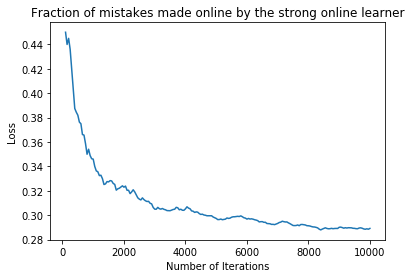

In [76]:
run_experiment(T=10000, N=8, net=0, model="bbm", gamma=0.1505)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.34
Fraction of mistakes by time 2000 0.3195
Fraction of mistakes by time 3000 0.32466666666666666
Fraction of mistakes by time 4000 0.31075
Fraction of mistakes by time 5000 0.3112
Fraction of mistakes by time 6000 0.31
Fraction of mistakes by time 7000 0.30742857142857144
Fraction of mistakes by time 8000 0.30275
Fraction of mistakes by time 9000 0.3025555555555556
Fraction of mistakes by time 10000 0.2983
Fraction of mistakes after 10000 iterations: 0.2983
Edges of weak learners:
 [0.1715 0.1715 0.1715 0.1715 0.1715 0.1665 0.1717 0.17   0.1549 0.1405
 0.1393 0.1322 0.1195 0.1294 0.1277 0.1064]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 74 %
Accuracy of weak learner 1 on the 2000 test images: 74 %
Accuracy of weak learner 2 on the 2000 test images: 74 %
Accuracy of weak learner 3 on the 2000 test images: 74 %
Accuracy of weak learner 4 on the 2000 test images: 74 %
Accuracy of weak learner 5

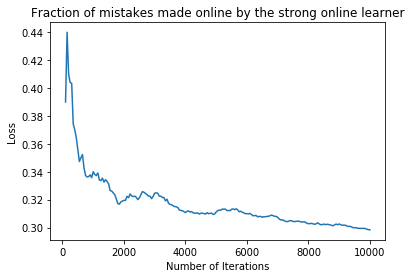

In [77]:
run_experiment(T=10000, N=16, net=0, model="bbm", gamma=0.0916)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.377
Fraction of mistakes by time 2000 0.3455
Fraction of mistakes by time 3000 0.3343333333333333
Fraction of mistakes by time 4000 0.32525
Fraction of mistakes by time 5000 0.321
Fraction of mistakes by time 6000 0.31366666666666665
Fraction of mistakes by time 7000 0.307
Fraction of mistakes by time 8000 0.302
Fraction of mistakes by time 9000 0.2995555555555556
Fraction of mistakes by time 10000 0.2971
Fraction of mistakes after 10000 iterations: 0.2971
Edges of weak learners:
 [0.1705 0.1705 0.1705 0.1705 0.1705 0.1705 0.1705 0.1705 0.1705 0.1734
 0.1765 0.1797 0.1721 0.1539 0.1465 0.1349 0.1342 0.1229 0.1334 0.09
 0.1044 0.1095 0.107  0.1216 0.1123 0.1286 0.1311 0.1209 0.1374 0.1203
 0.1156 0.1042]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 76 %
Accuracy of weak learner 1 on the 2000 test images: 76 %
Accuracy of weak learner 2 on the 2000 test images: 76 %
Accuracy of weak learner 3 on 

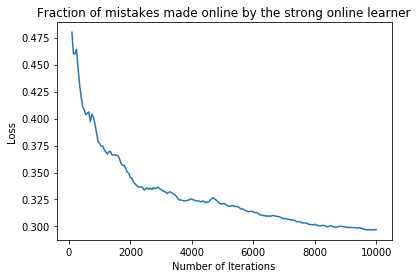

In [79]:
run_experiment(T=10000, N=32, net=0, model="bbm", gamma=0.0457)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.385
Fraction of mistakes by time 2000 0.3705
Fraction of mistakes by time 3000 0.35333333333333333
Fraction of mistakes by time 4000 0.3505
Fraction of mistakes by time 5000 0.352
Fraction of mistakes by time 6000 0.3471666666666667
Fraction of mistakes by time 7000 0.3442857142857143
Fraction of mistakes by time 8000 0.341375
Fraction of mistakes by time 9000 0.3382222222222222
Fraction of mistakes by time 10000 0.3364
Fraction of mistakes after 10000 iterations: 0.3364
Edges of weak learners:
 [0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621
 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621
 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621 0.1621
 0.1621 0.1621 0.2069 0.1917 0.1718 0.1461 0.1393 0.111  0.1037 0.0957
 0.0885 0.1138 0.0977 0.1001 0.1391 0.1217 0.1528 0.1434 0.1543 0.1083
 0.1488 0.1234 0.1452 0.1553 0.1712 0.1678 0.1899 0.1618 0.1915 0.1871
 0.1612 0.185

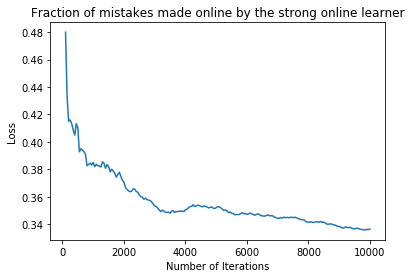

In [15]:
run_experiment(T=10000, N=64, net=0, model="bbm", gamma=0.08)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.379
Fraction of mistakes by time 2000 0.3585
Fraction of mistakes by time 3000 0.34833333333333333
Fraction of mistakes by time 4000 0.3405
Fraction of mistakes by time 5000 0.3338
Fraction of mistakes by time 6000 0.3313333333333333
Fraction of mistakes by time 7000 0.3334285714285714
Fraction of mistakes by time 8000 0.33325
Fraction of mistakes by time 9000 0.332
Fraction of mistakes by time 10000 0.33
Fraction of mistakes after 10000 iterations: 0.33
Edges of weak learners:
 [0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17   0.17
 0.17   0.17   0.17   0.17   0.2118 0.1709

Accuracy of weak learner 116 on the 2000 test images: 57 %
Accuracy of weak learner 117 on the 2000 test images: 57 %
Accuracy of weak learner 118 on the 2000 test images: 57 %
Accuracy of weak learner 119 on the 2000 test images: 57 %
Accuracy of weak learner 120 on the 2000 test images: 57 %
Accuracy of weak learner 121 on the 2000 test images: 57 %
Accuracy of weak learner 122 on the 2000 test images: 57 %
Accuracy of weak learner 123 on the 2000 test images: 57 %
Accuracy of weak learner 124 on the 2000 test images: 57 %
Accuracy of weak learner 125 on the 2000 test images: 57 %
Accuracy of weak learner 126 on the 2000 test images: 57 %
Accuracy of weak learner 127 on the 2000 test images: 57 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 57 %


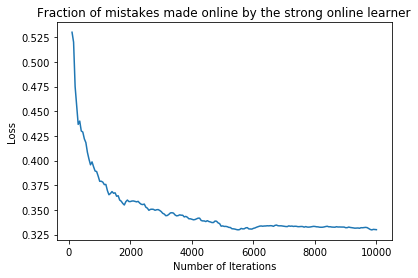

In [22]:
run_experiment(T=10000, N=128, net=0, model="bbm", gamma=0.0735)

# Different number of iterations T

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.335
Fraction of mistakes by time 2000 0.3195
Fraction of mistakes after 2500 iterations: 0.3148
Edges of weak learners:
 [0.1648 0.1648 0.1628 0.1548 0.1544 0.1428 0.1384 0.106 ]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 70 %
Accuracy of weak learner 1 on the 2000 test images: 70 %
Accuracy of weak learner 2 on the 2000 test images: 64 %
Accuracy of weak learner 3 on the 2000 test images: 70 %
Accuracy of weak learner 4 on the 2000 test images: 74 %
Accuracy of weak learner 5 on the 2000 test images: 74 %
Accuracy of weak learner 6 on the 2000 test images: 51 %
Accuracy of weak learner 7 on the 2000 test images: 68 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 71 %


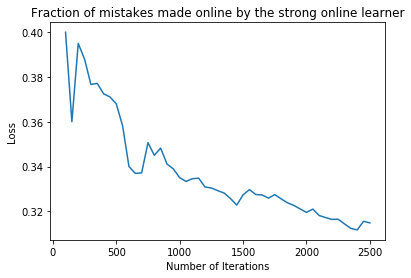

In [19]:
run_experiment(T=2500, N=8, net=0, model="bbm", gamma=0.106)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.365
Fraction of mistakes by time 2000 0.3315
Fraction of mistakes by time 3000 0.31566666666666665
Fraction of mistakes by time 4000 0.311
Fraction of mistakes by time 5000 0.3046
Fraction of mistakes after 5000 iterations: 0.3046
Edges of weak learners:
 [0.1554 0.1504 0.1652 0.1648 0.166  0.1566 0.1644 0.1386]

EVALUATING WEAK LEARNERS
Accuracy of weak learner 0 on the 2000 test images: 72 %
Accuracy of weak learner 1 on the 2000 test images: 69 %
Accuracy of weak learner 2 on the 2000 test images: 61 %
Accuracy of weak learner 3 on the 2000 test images: 72 %
Accuracy of weak learner 4 on the 2000 test images: 73 %
Accuracy of weak learner 5 on the 2000 test images: 72 %
Accuracy of weak learner 6 on the 2000 test images: 73 %
Accuracy of weak learner 7 on the 2000 test images: 69 %


EVALUATING MODEL
Accuracy of the network on the 2000 test images: 74 %


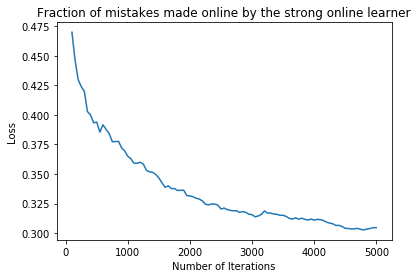

In [21]:
run_experiment(T=5000, N=8, net=0, model="bbm", gamma=0.1106)

Evaluating Online BBM:

Fraction of mistakes by time 1000 0.362
Fraction of mistakes by time 2000 0.3345
Fraction of mistakes by time 3000 0.32366666666666666
Fraction of mistakes by time 4000 0.3145
Fraction of mistakes by time 5000 0.3068
Fraction of mistakes by time 6000 0.303
Fraction of mistakes by time 7000 0.2975714285714286
Fraction of mistakes by time 8000 0.2935
Fraction of mistakes by time 9000 0.2886666666666667
Fraction of mistakes by time 10000 0.2876
Fraction of mistakes by time 11000 0.2868181818181818
Fraction of mistakes by time 12000 0.28525
Fraction of mistakes by time 13000 0.2833846153846154
Fraction of mistakes by time 14000 0.2827857142857143
Fraction of mistakes by time 15000 0.28213333333333335
Fraction of mistakes by time 16000 0.280875
Fraction of mistakes by time 17000 0.2802352941176471
Fraction of mistakes by time 18000 0.28
Fraction of mistakes by time 19000 0.2786842105263158
Fraction of mistakes by time 20000 0.2786
Fraction of mistakes after 20000 ite

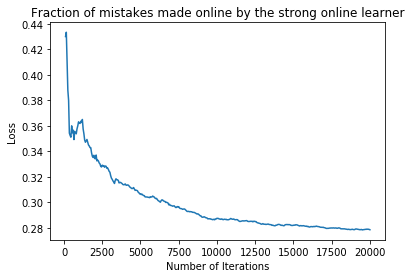

In [18]:
run_experiment(T=20000, N=8, net=0, model="bbm", gamma=0.1505)

## Citations

Code for CNN: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Online algorithms: http://proceedings.mlr.press/v37/beygelzimer15.pdf